In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ast
from scipy.stats import ttest_rel
import math
import seaborn as sns

ACTIVE_SHAM = 'Sham'
GROUP1 = 'PRE'
GROUP2 = 'POST'
N = 32
LINK_DIFF = 2
ASYM_DIFF = 0
mapping = {0: 'theta', 1: 'alpha', 2: 'beta'}

DF                        index    links                                     \
                       index theta-g1 theta-g2 alpha-g1 alpha-g2 beta-g1   
0       Sham-Geeta-PrevsPost      209      215      183      209     208   
1    Sham-Jitendra-PrevsPost      181      216      154      203     178   
2       Sham-Jyoti-PrevsPost      188      205      187      177     201   
3     Sham-Kuldeep-PrevsPost      197      211      182      207     193   
4       Sham-Seema-PrevsPost      197      203      199      191     204   
5  Sham-VijayLaxmi-PrevsPost      206      199      194      199     211   

          asymmetry                      ...      eloc  \
  beta-g2  theta-g1  theta-g2  alpha-g1  ...   beta-g2   
0     222  1.059259  0.935484  1.390000  ...  0.785628   
1     195  0.920000  1.141844  0.982456  ...  0.196327   
2     187  1.000000  0.780488  0.932331  ...  0.746599   
3     221  1.045455  1.125000  0.914729  ...  0.174340   
4     214  1.234783  1.098592  1.708333 

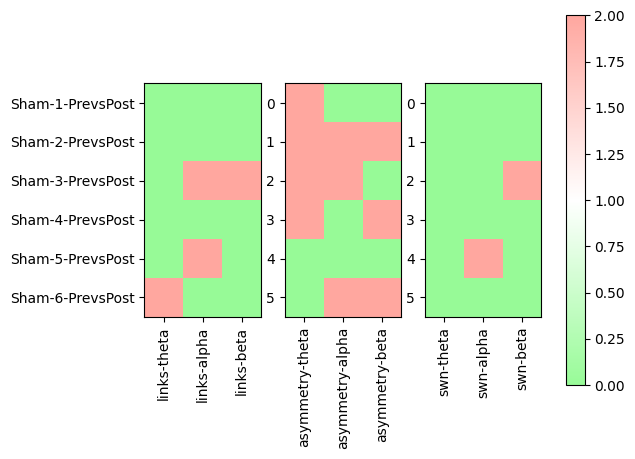

In [6]:
existing_file = f"comparison-results/result-{ACTIVE_SHAM}.xlsx"
df = pd.read_excel(existing_file, header=[0,1])

df_without_rows = df.drop(df.index[0:len(df)//2-3])
df_without_columns = df_without_rows.drop(df_without_rows.columns[0:len(df)//2-3], axis=1)
df = df_without_columns
print("DF", df)

colors = [(0.596, 0.984, 0.596), (1,1,1), (1.000, 0.655, 0.625)] # white, green, blue (0.725, 0.855, 1.000),, red
values = [0,1,2]
cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors, N=256)

condition_matrix = np.zeros((len(df), (len(df.columns)-N-1) // 2))
for j in range(len(df)): # rows
    insignificant_bands  = []
    for i in range(1, len(df.columns)-N, 2): # cols  
        # LINKS  
        if i in range(1,6):
            if (df.iloc[j, i]==0 or df.iloc[j, i+1]==0) or (np.abs(df.iloc[j, i] - df.iloc[j, i + 1]) <= LINK_DIFF): # links difference --- disconnected graph or almost equal links
                condition_matrix[j, i // 2] = 1 # white
                if (df.iloc[j, i]==0 or df.iloc[j, i+1]==0): # disconnected graph
                    df.iloc[j, i]=None
                    df.iloc[j, i + 1]=None
                    insignificant_bands.append(i)
            elif df.iloc[j, i] < df.iloc[j, i + 1]: # post links > pre links
                condition_matrix[j, i // 2] = 0 # green 
            else: # pre links > post links
                condition_matrix[j, i // 2] = 2 # red

        # ASYMMETRY
        elif i in range(6, 12):
            if i-6 in insignificant_bands or (np.abs(np.abs(df.iloc[j, i] - 1) - np.abs(df.iloc[j, i+1] - 1)) == ASYM_DIFF): # disconnected graph or almost symmetric graphs
                condition_matrix[j, i // 2] = 1 # white
                if i-6 in insignificant_bands: # disocnnected graph
                    df.iloc[j, i]=None
                    df.iloc[j, i + 1]=None
            elif np.abs(df.iloc[j, i] - 1) > np.abs(df.iloc[j, i+1] - 1): # pre asymmetry > post asymmetry
                condition_matrix[j, i//2] = 0 # green
            else: #  post asymmetry > pre asymmetry
                condition_matrix[j, i//2] = 2 # red

        # SWN 
        elif i in range(12,18):
            if i-12 in insignificant_bands or (df.iloc[j, i] == df.iloc[j, i+1] and df.iloc[j,i] == 0.0): # Disconnected graphs or incomparable graphs
                condition_matrix[j, i // 2] = 1 # white
                df.iloc[j, i]=None
                df.iloc[j, i+1]=None
            elif df.iloc[j, i] > df.iloc[j, i+1]: # pre swn > post swn
                condition_matrix[j, i // 2] = 2 # red
            else: # post swn >= pre swn
                condition_matrix[j, i // 2] = 0 # green
                

lis = [f"{df.columns[i][0]}-{df.columns[i][1].split('-')[0]}" for i in range(1, len(df.columns)-N-1, 2)]
y_list = [f"{elem.split('-')[0]}-{i+1}-{elem.split('-')[-1]}" for i, elem in enumerate(list(df.iloc[:, 0]))]

def sub_lists(lst):
    n = len(lst)
    size = n // len(mapping)
    return [lst[i*size:(i+1)*size] for i in range(3)]

sub_list = sub_lists(lis)
divided_matrix = np.hsplit(condition_matrix, 3)

f, axarr = plt.subplots(1,3) 
for count, i in enumerate(mapping):
    # plt.figure(figsize=(8, 6))
    im = axarr[count].imshow(divided_matrix[count], cmap=cmap)
    axarr[count].set_xticks(range(((len(df.columns)-N-1)// 2)//3), sub_list[count], rotation='vertical')
axarr[0].set_yticks(range(len(df)), y_list)
f.colorbar(im, ax=axarr.ravel().tolist())
plt.show()

In [ ]:
# existing_file = f"comparison-results/result-Active.xlsx"
# df = pd.read_excel(existing_file, header=[0,1])
# df_without_rows = df.drop(df.index[0:len(df)//2+1])
# df_without_columns = df_without_rows.drop(df_without_rows.columns[0:len(df)//2+1], axis=1)
# active_data = df_without_columns
# existing_file = f"comparison-results/result-Sham.xlsx"
# df = pd.read_excel(existing_file)
# df_without_rows = df.drop(df.index[0:len(df)//2+1])
# df_without_columns = df_without_rows.drop(df_without_rows.columns[0:len(df)//2+1], axis=1)
# sham_data = df_without_columns

# combined_data = pd.concat([active_data, sham_data], axis=0)


# # Add the new row to the DataFrame
# for index, row in active_data.iterrows():
#     # print(f"Row {index}:\n{row}\n")
#     print(len(active_data))
#     active_data.loc[len(active_data)] = row

# print(active_data)

# Assuming 'combined_data' is your DataFrame
# print(tabulate(combined_data, headers='keys', tablefmt='psql'))


# # Create a DataFrame with your data
# data = {
#     'group': ['active']*12 + ['placebo']*6,
#     'small_worldedness': [1.2, 1.3, 1.4, 1.1, 1.5, 1.6, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3],
#     'num_links': [100, 110, 95, 105, 115, 90, 100, 110, 95, 105, 100, 110, 95, 105, 100, 110, 95, 105, 100, 110],
#     'asymmetry': [0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2],
#     'brain_region': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B']
# }
# df = pd.DataFrame(data)

# # Fit a linear regression model
# model = smf.ols(formula='small_worldedness ~ group + num_links + asymmetry + brain_region', data=df)
# results = model.fit()

# # Print the regression results
# print(results.summary())


# Assuming you have loaded the data into DataFrames active_data and sham_data

# Combine the data into a single DataFrame

# # Assume 'SWI' is the dependent variable and 'freq_band_1_g1' and 'freq_band_1_g2' are independent variables
# X = combined_data[['freq_band_1_g1', 'freq_band_1_g2']]
# X = sm.add_constant(X)  # Add a constant term to the independent variables
# y = combined_data['SWI']

# # Fit the linear regression model
# model = sm.OLS(y, X).fit()

# # Print the model summary
# print(model.summary())


In [7]:
swn_values1, swn_values2 = {'theta' : [], 'alpha': [], 'beta': []} , {'theta' : [], 'alpha': [], 'beta': []}
asymmetry_values1, asymmetry_values2 = {'theta' : [], 'alpha': [], 'beta': []}, {'theta' : [], 'alpha': [], 'beta': []}
links_values1, links_values2 = {'theta' : [], 'alpha': [], 'beta': []}, {'theta' : [], 'alpha': [], 'beta': []}
# hub_values1, hub_values2 = {'theta' : [], 'alpha': [], 'beta': []}, {'theta' : [], 'alpha': [], 'beta': []}

master_dict = {'links_values': [links_values1, links_values2], 'asymmetry_values': [asymmetry_values1, asymmetry_values2], \
               'swn_values': [swn_values1, swn_values2]}

for j in range(len(df)): # rows
    for k in range(1, len(df.columns)-N-1, 2): # cols 
        if k in range(1,6):
            para = 'links_values'
        elif k in range(6, 12):
            para = 'asymmetry_values'
        elif k in range(12, 18):
            para = 'swn_values'

        if k%6 == 1:
            master_dict[para][0]['theta'].append(df.iloc[j, k])
            master_dict[para][1]['theta'].append(df.iloc[j, k+1])
        elif k%6 == 3:
            master_dict[para][0]['alpha'].append(df.iloc[j, k])
            master_dict[para][1]['alpha'].append(df.iloc[j, k+1])
        elif k%6 == 5:
            master_dict[para][0]['beta'].append(df.iloc[j, k])
            master_dict[para][1]['beta'].append(df.iloc[j, k+1])

    
        # for k in range(len(df.columns)-6, len(df.columns)-3, 1): #cols
        #     print(k, "&&&&&&&")
        #     print(len(ast.literal_eval(df.iloc[j, k])))

theta
theta
theta


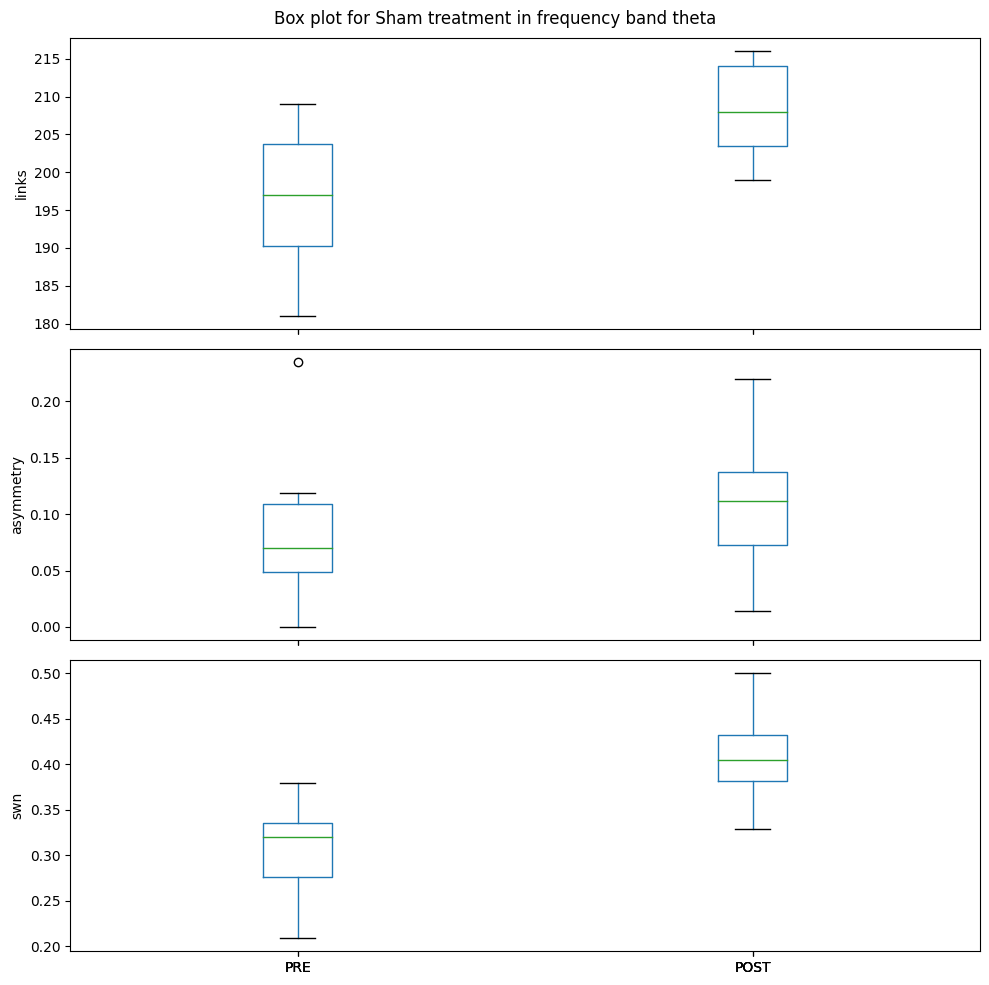

links, p-value: 0.09454713141969677
asymmetry, p-value: 0.7092131685034189
swn, p-value: 0.0155754578998429
Significant difference for parameter: swn for freq band: theta
alpha
alpha
alpha


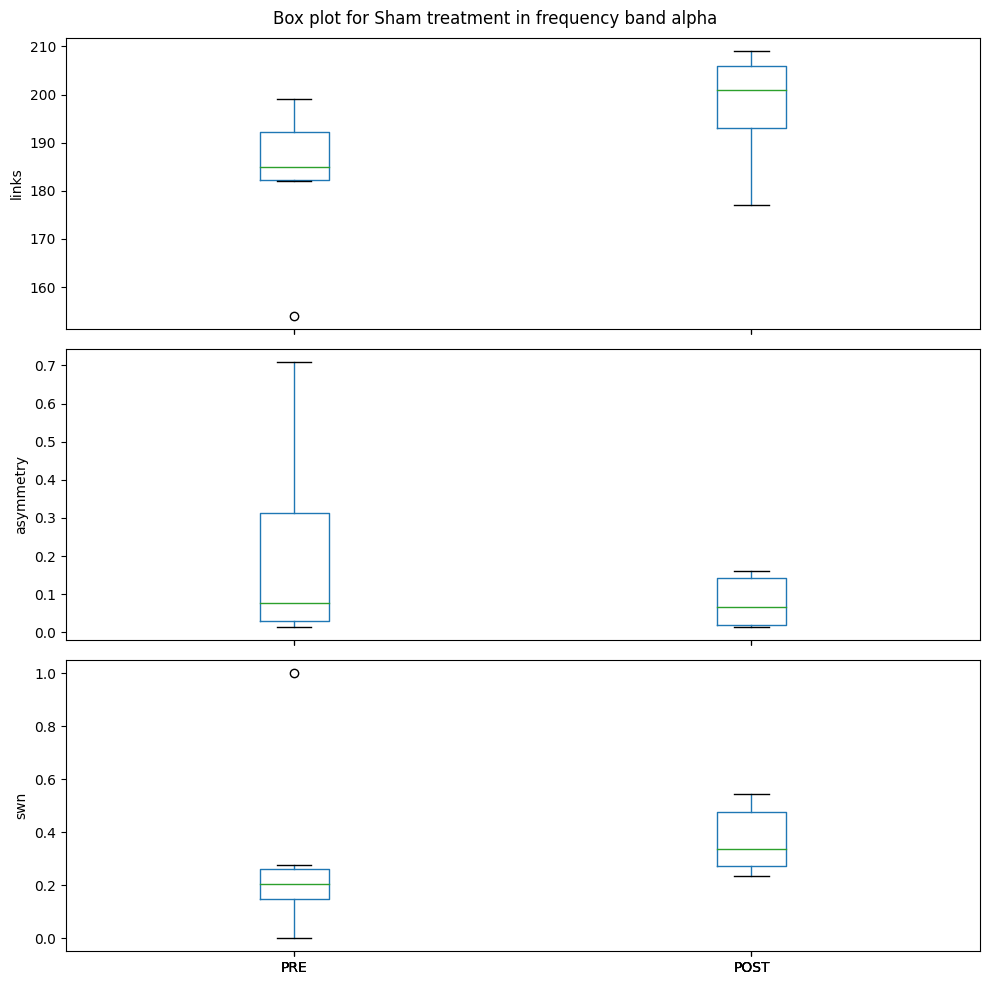

links, p-value: 0.1821157415179071
asymmetry, p-value: 0.3696859924281306
swn, p-value: 0.5639058935694304
beta
beta
beta


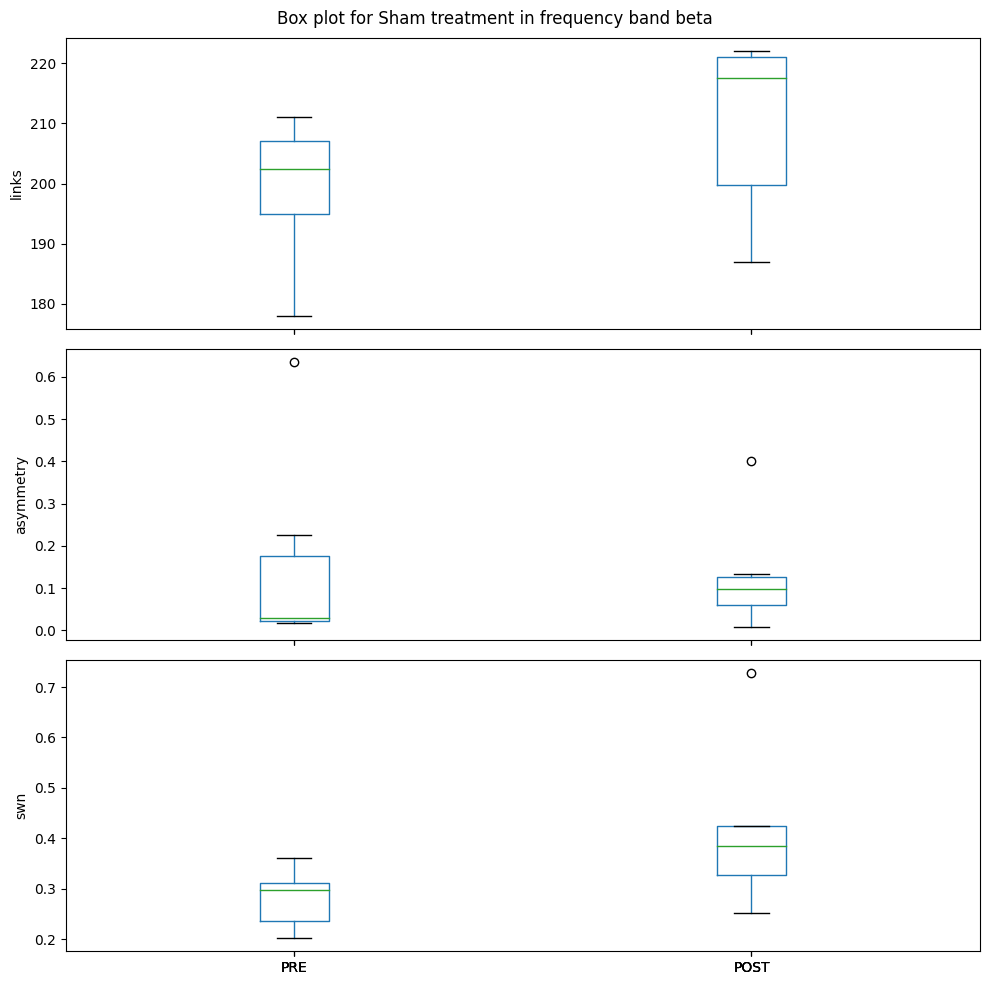

links, p-value: 0.11376439644603527
asymmetry, p-value: 0.8209976995336383
swn, p-value: 0.14650213222380373


In [8]:
for map in mapping: 
    g1_group_measures = pd.DataFrame({
        # master_dict['swn_values'][0][mapping[map]] can be replaced with swn_values1[mapping[map]]
        'links': master_dict['links_values'][0][mapping[map]],
        'asymmetry':  [abs(x - 1) for x in master_dict['asymmetry_values'][0][mapping[map]]],
        'swn': master_dict['swn_values'][0][mapping[map]],
    })


    g2_group_measures = pd.DataFrame({
        'links': master_dict['links_values'][1][mapping[map]],
        'asymmetry': [abs(x - 1) for x in master_dict['asymmetry_values'][1][mapping[map]]],
        'swn': master_dict['swn_values'][1][mapping[map]],
    })

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    parameters = ['links', 'asymmetry', 'swn']

    for i, param in enumerate(parameters):
        print(mapping[map])
        df = pd.DataFrame({GROUP1: g1_group_measures[param], GROUP2: g2_group_measures[param]})
        df.boxplot(ax=axes[i], grid=False)
        # axes[i].boxplot([g1_group_measures[param], g2_group_measures[param]], labels=[GROUP1, GROUP2])
        axes[i].set_ylabel(param)

    fig.suptitle(f'Box plot for {ACTIVE_SHAM} treatment in frequency band {mapping[map]}')
    plt.tight_layout()
    plt.show()

    # Perform t-test for each parameter
    for param in parameters:
        # print("*********", g1_group_measures[param], g2_group_measures[param])
        t_stat, p_value = ttest_rel(g1_group_measures[param].dropna(), g2_group_measures[param].dropna())
        print(f"{param}, p-value: {p_value}")
        if p_value < 0.05:
            print(f"Significant difference for parameter: {param} for freq band: {mapping[map]}")